# 02/04/21 - This notebook loads the image, psf, and noise map for the r-band observation that was prepared in the data prep notebook... a first attempt at modeling. 

In [1]:
%matplotlib inline

from pyprojroot import here

workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autofit as af  # <- This library is used for non-linear fitting.
import autolens as al
import autolens.plot as aplt

/data/sknabel/autoz_lens_model
Working Directory has been set to `/data/sknabel/autoz_lens_model`


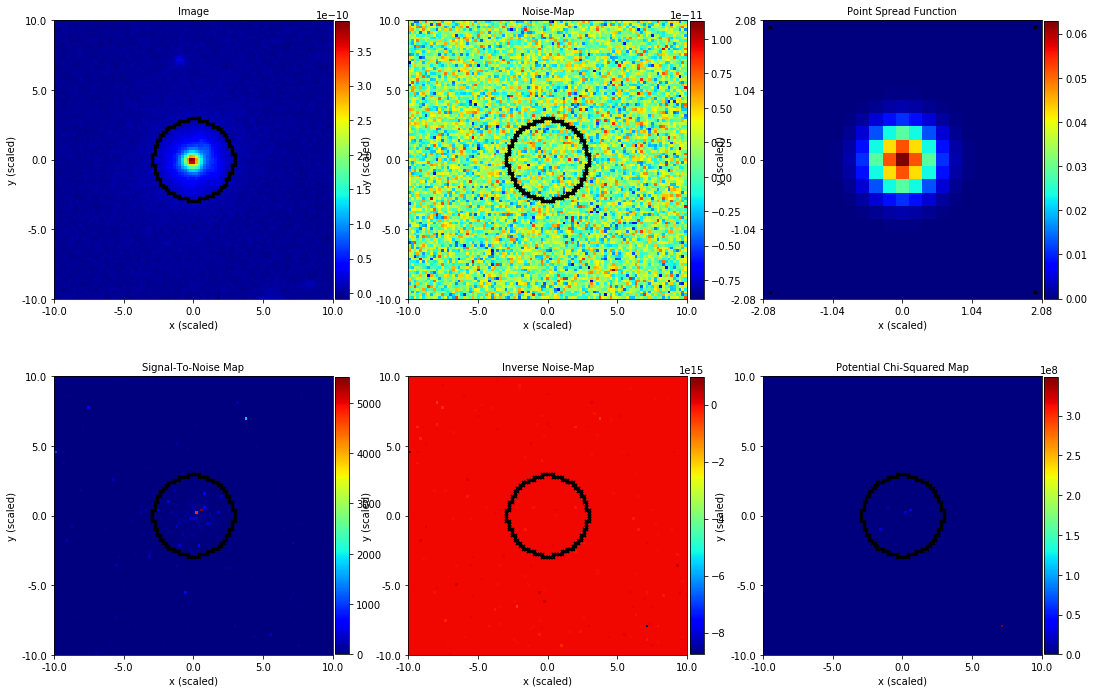

In [2]:
# paths
autoz_path = '/data/sknabel/autoz_lens_model/'
file_path = f'{autoz_path}files/'
csv_path = f'{file_path}csv/'
fits_path = f'{file_path}fits/'
folder = f'{fits_path}G3575500_1906/'

imaging = al.Imaging.from_fits(image_path=path.join(folder, '1906_r.fits'),
                              noise_map_path=path.join(folder, '1906_r_noisemap.fits'),
                              psf_path=path.join(folder, '1906_r_psf_resized.fits'),
                               pixel_scales=0.198)
mask = al.Mask2D.circular(
    shape_2d=imaging.shape_2d, pixel_scales=imaging.pixel_scales, sub_size=1, radius=3.0
)
visuals_2d = aplt.Visuals2D(mask=mask)

imaging_plotter = aplt.ImagingPlotter(
    imaging=imaging, visuals_2d=aplt.Visuals2D(mask=mask)
)
imaging_plotter.subplot_imaging()

In [3]:
print(imaging.image.shape_2d, imaging.noise_map.shape_2d, imaging.psf.shape_2d)

(101, 101) (101, 101) (21, 21)


In [4]:
# set up grid
settings_masked_imaging = al.SettingsMaskedImaging(grid_class=al.Grid)#, psf_shape_2d=imaging.psf.shape_2d)

settings = al.SettingsPhaseImaging(settings_masked_imaging=settings_masked_imaging)

In [5]:
#set up lens and source - can I not use a source and just fit the lens?
lens = al.GalaxyModel(
    redshift=0.232537, bulge=al.lp.EllipticalSersic, mass=al.mp.EllipticalIsothermal
)
#source?

In [6]:
# set priors
# lens position
lens.mass.centre_0 = af.UniformPrior(lower_limit=-0.1, upper_limit=0.1)
lens.mass.centre_1 = af.UniformPrior(lower_limit=-0.1, upper_limit=0.1)
lens.bulge.centre_0 = af.UniformPrior(lower_limit=-0.1, upper_limit=0.1)
lens.bulge.centre_1 = af.UniformPrior(lower_limit=-0.1, upper_limit=0.1)
# einstein radius
lens.mass.einstein_radius = af.GaussianPrior(mean=1.0, sigma=0.3)
# effective radius
lens.bulge.effective_radius = af.UniformPrior(lower_limit=0.0, upper_limit=3.0)

In [7]:
# set up phase
phase = al.PhaseImaging(
    search=af.DynestyStatic(
        path_prefix="files", name="G3575500", n_live_points=40
    ),
    settings=settings,
    galaxies=af.CollectionPriorModel(lens=lens),#, source=source),
)

In [8]:
# run the phase
print('Phase running...')
phase_result = phase.run(dataset=imaging, mask=mask)
print('Work complete!')

Phase running...


INFO:root:Generating initial samples of model, which are subject to prior limits and other constraints.
/soft/anaconda3/lib/python3.7/site-packages/dynesty/dynesty.py:373: UserWarning: A note of caution: having `nlive < ndim * (ndim + 1) // 2` may result in unconstrained bounding distributions.
  warnings.warn("A note of caution: "
INFO:root:No Dynesty samples found, beginning new non-linear search. 
128it [00:08,  3.68it/s, bound: 1 | nc: 5 | ncall: 1286 | eff(%):  9.953 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  0.049] /soft/anaconda3/lib/python3.7/site-packages/dynesty/sampling.py:216: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
130it [00:08,  4.59it/s, bound: 1 | nc: 12 | ncall: 1305 | eff(%):  9.962 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  0.049]/soft/anaconda3/lib/python3.7/

KeyError: 'key dataset not found in paths /data/sknabel/autoz_lens_model/config\n/soft/anaconda3/lib/python3.7/site-packages/autofit/config\n/data/sknabel/autoz_lens_model/output'